In [ ]:
!pip install captum

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jul  5 11:23:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    34W / 250W |    955MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training'
/content/drive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training


### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
import sys
# sys.path.insert(0, '../models')
# from krs_inflow_model import SimpleMLP

### Read Datasets

In [ ]:
inflow_df = pd.read_csv('../dataset/reservoir_rainfall_dataset_en.csv')
inflow_df = inflow_df[inflow_df['RESERVOIR'] == 'K.R.S']
print(inflow_df.shape)
inflow_df.head()

(3274, 11)


,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,RAINFALL,SEASON
0,K.R.S,46.42,122.59,2029.0,2000.0,2011,1,1,0,0.0226,WINTER
1,K.R.S,46.54,122.68,3084.0,1490.0,2011,1,2,1,0.0226,WINTER
2,K.R.S,46.64,122.75,2776.0,1491.0,2011,1,3,2,0.0226,WINTER
3,K.R.S,46.69,122.79,2311.0,1491.0,2011,1,4,3,0.0226,WINTER
4,K.R.S,46.70,122.80,1847.0,1491.0,2011,1,5,4,0.0226,WINTER


In [ ]:
rainfall_df = pd.read_csv('../dataset/Rainfall 2010-2020/rainfall_dataset.csv')
print(rainfall_df.shape)
rainfall_df.head()

(357, 14)


,DISTRICTS,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,BAGALKOTE,2008,0.0,16.7,94.2,10.3,37.5,46.5,28.3,60.2,135.4,60.3,27.2,0.3
1,BAGALKOTE,2009,0.0,0.0,2.9,14.8,66.3,119.0,41.7,107.3,195.6,220.1,28.8,31.2
2,BAGALKOTE,2010,13.4,0.1,0.0,10.6,57.4,109.7,89.6,149.3,64.2,58.3,83.2,0.4
3,BAGALKOTE,2011,0.0,1.9,0.4,39.2,81.0,74.9,77.6,107.0,57.1,90.4,0.0,0.0
4,BENGALURU RURAL,2008,0.0,2.1,100.9,15.2,100.7,11.8,149.1,223.0,103.9,150.4,25.2,2.3


In [ ]:
departure_df = pd.read_csv('../dataset/Rainfall 2010-2020/rainfall_departure_dataset.csv')
print(departure_df.shape)
departure_df.head()

(334, 14)


,DISTRICTS,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,BAGALKOTE,2008,-100.0,882.0,1677.0,-57.0,-35.0,-37.0,-63.0,-16.0,-7.0,-41.0,-2.0,-95.0
1,BAGALKOTE,2009,-100.0,-100.0,-45.0,-38.0,14.0,62.0,-45.0,50.0,35.0,116.0,4.0,380.0
2,BAGALKOTE,2010,1118.0,-94.0,-100.0,-56.0,-1.0,50.0,18.0,109.0,-56.0,-43.0,200.0,-94.0
3,BAGALKOTE,2011,-100.0,27.0,-91.0,67.0,41.0,-6.0,5.0,48.0,-58.0,-20.0,-100.0,-100.0
4,BAGALKOTE,2012,-100.0,-99.0,-100.0,36.0,-69.0,-59.0,-26.0,-6.0,-64.0,-17.0,65.0,-100.0


### Dataset Transformation

In [ ]:
inflow_df = inflow_df.drop(columns=['RESERVOIR', 'PRESENT_STORAGE_TMC', 'RES_LEVEL_FT', 'OUTFLOW_CUECS', 'DATE'])
inflow_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DAY,RAINFALL,SEASON
0,2029.0,2011,1,0,0.0226,WINTER
1,3084.0,2011,1,1,0.0226,WINTER
2,2776.0,2011,1,2,0.0226,WINTER
3,2311.0,2011,1,3,0.0226,WINTER
4,1847.0,2011,1,4,0.0226,WINTER


In [ ]:
rainfall_df = rainfall_df.melt(id_vars=['DISTRICTS', 'YEAR'], var_name='MONTH', value_name='RAINFALL')
rainfall_df.head()

,DISTRICTS,YEAR,MONTH,RAINFALL
0,BAGALKOTE,2008,JAN,0.0
1,BAGALKOTE,2009,JAN,0.0
2,BAGALKOTE,2010,JAN,13.4
3,BAGALKOTE,2011,JAN,0.0
4,BENGALURU RURAL,2008,JAN,0.0


In [ ]:
departure_df = departure_df.melt(id_vars=['DISTRICTS', 'YEAR'], var_name='MONTH', value_name='DEPARTURE')
departure_df.head()

,DISTRICTS,YEAR,MONTH,DEPARTURE
0,BAGALKOTE,2008,JAN,-100.0
1,BAGALKOTE,2009,JAN,-100.0
2,BAGALKOTE,2010,JAN,1118.0
3,BAGALKOTE,2011,JAN,-100.0
4,BAGALKOTE,2012,JAN,-100.0


In [ ]:
rainfall_df = rainfall_df[rainfall_df['DISTRICTS'] == 'KODAGU']
departure_df = departure_df[departure_df['DISTRICTS'] == 'KODAGU']

rainfall_df.shape, departure_df.shape

((156, 4), (156, 4))

In [ ]:
month_df = pd.DataFrame.from_dict({1: 'JAN', 2: 'FEB', 3: 'MAR', 4: 'APR', 5: 'MAY', 6: 'JUN',
                                   7: 'JUL', 8: 'AUG', 9: 'SEP', 10: 'OCT', 11: 'NOV', 12: 'DEC'}, orient='index').reset_index()
month_df.columns = ['index', 'MONTH']
month_df.head()

,index,MONTH
0,1,JAN
1,2,FEB
2,3,MAR
3,4,APR
4,5,MAY


In [ ]:
rainfall_departure_df = pd.merge(left=rainfall_df, right=departure_df, how='outer', on=['MONTH', 'YEAR', 'DISTRICTS']).merge(month_df, on='MONTH')
rainfall_departure_df.drop(columns=['DISTRICTS', 'MONTH'], inplace=True)
rainfall_departure_df.rename(columns={'index': 'MONTH'}, inplace=True)
rainfall_departure_df.head()

,YEAR,RAINFALL,DEPARTURE,MONTH
0,2008,0.0,-100.0,1
1,2009,0.0,-100.0,1
2,2010,12.4,188.0,1
3,2011,0.7,-80.0,1
4,2012,0.5,-86.0,1


### Dataset and DataLoader

In [ ]:
month_le = LabelEncoder().fit(inflow_df['MONTH'].unique())
day_le = LabelEncoder().fit(inflow_df['DAY'].unique())
season_le = LabelEncoder().fit(inflow_df['SEASON'].unique())

In [ ]:
train_inflow_df = inflow_df[inflow_df['YEAR'] < 2020]
val_inflow_df = inflow_df[inflow_df['YEAR'] >= 2020]

train_inflow_df.shape, val_inflow_df.shape

((2944, 6), (330, 6))

In [ ]:
class InflowDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, index):
        inflow, year, month, day, rainfall, season = self.df.iloc[index].values
        monthly_rainfall = rainfall_departure_df[(rainfall_departure_df['YEAR'] == year) & (rainfall_departure_df['MONTH'] == month)]['RAINFALL'].values
        prev_rainfall_departure_df = rainfall_departure_df[(rainfall_departure_df['YEAR'] < year) & (rainfall_departure_df['MONTH'] == month)].sort_values('YEAR', ascending=False).head(3)
        prev_avg_rainfall = prev_rainfall_departure_df['RAINFALL'].values.mean()
        prev_avg_departure = prev_rainfall_departure_df['DEPARTURE'].values.mean()
        
        month_transformed = month_le.transform([month])
        day_transformed = day_le.transform([day])
        season_transformed = season_le.transform([season])

        return (torch.tensor(month_transformed[0]), \
                torch.tensor(day_transformed[0]), \
                torch.tensor(season_transformed[0]), \
                torch.FloatTensor([prev_avg_rainfall, prev_avg_departure])), torch.FloatTensor([inflow])
    
    def __len__(self):
        return self.df.shape[0]

In [ ]:
train_ds = InflowDataset(train_inflow_df)
val_ds = InflowDataset(val_inflow_df)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=2)

### Model

In [ ]:
import torch
import torch.nn as nn
class SimpleMLP(nn.Module):
    def __init__(self, nmonth, nday, nseason):
        super().__init__()
        self.month_emb = nn.Embedding(num_embeddings=nmonth, embedding_dim=128)
        self.day_emb = nn.Embedding(num_embeddings=nday, embedding_dim=128)
        self.season_emb = nn.Embedding(num_embeddings=nseason, embedding_dim=128)
        self.prev_data_layer = nn.Sequential(
            nn.Linear(in_features=2, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU()
        )
        self.output_layer = nn.Sequential(
            nn.Linear(in_features=128*4, out_features=768),
            nn.LeakyReLU(),
            nn.Linear(in_features=768, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=1),
            nn.ReLU()
        )
    
    def forward(self, x_month, x_day, x_season, x_prev_data):
        month_out = self.day_emb(x_month)
        day_out = self.day_emb(x_day)
        season_out = self.season_emb(x_season)
        prev_data_out = self.prev_data_layer(x_prev_data)

        return self.output_layer(torch.cat([month_out, day_out, season_out, prev_data_out], axis=1))
    
    def weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

### Training

In [ ]:
def train(model, epochs, lr):
    opt = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0

        model.train()
        for xb, yb in train_dl:
            x_month = xb[0].cuda()
            x_day = xb[1].cuda()
            x_season = xb[2].cuda()
            x_prev_data = xb[3].cuda()
            yb = yb.cuda()

            y_hat = model(x_month, x_day, x_season, x_prev_data)
            loss = criterion(y_hat, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for xb, yb in val_dl:
                x_month = xb[0].cuda()
                x_day = xb[1].cuda()
                x_season = xb[2].cuda()
                x_prev_data = xb[3].cuda()
                yb = yb.cuda()

                y_hat = model(x_month, x_day, x_season, x_prev_data)
                loss = criterion(y_hat, yb)

                val_loss += loss.item()
                
        print(f'Epoch - {epoch+1} | Train Loss - {round(train_loss / len(train_dl), 2)} | Val Loss - {round(val_loss / len(val_dl), 2)}')

In [ ]:
model = SimpleMLP(len(month_le.classes_), len(day_le.classes_), len(season_le.classes_)).cuda()
model.weight_init()

In [ ]:
train(model, epochs=10, lr=1e-02)

Epoch - 1 | Train Loss - 38564604.68 | Val Loss - 14361010.85
Epoch - 2 | Train Loss - 31020918.01 | Val Loss - 15402177.16
Epoch - 3 | Train Loss - 27900695.0 | Val Loss - 15880735.32
Epoch - 4 | Train Loss - 27295157.21 | Val Loss - 16404065.92
Epoch - 5 | Train Loss - 26652484.66 | Val Loss - 17849556.52
Epoch - 6 | Train Loss - 25636782.32 | Val Loss - 19727461.91
Epoch - 7 | Train Loss - 26313846.18 | Val Loss - 14481016.23
Epoch - 8 | Train Loss - 25617064.74 | Val Loss - 16141006.99
Epoch - 9 | Train Loss - 25337961.9 | Val Loss - 15461559.44
Epoch - 10 | Train Loss - 25264732.83 | Val Loss - 18171097.91


In [ ]:
train(model, epochs=400, lr=1e-03)

Epoch - 1 | Train Loss - 23033264.53 | Val Loss - 15357693.43
Epoch - 2 | Train Loss - 22636043.13 | Val Loss - 15636609.2
Epoch - 3 | Train Loss - 22255109.43 | Val Loss - 15347365.12
Epoch - 4 | Train Loss - 21960539.4 | Val Loss - 16132119.09
Epoch - 5 | Train Loss - 21735286.24 | Val Loss - 15138026.16
Epoch - 6 | Train Loss - 21354847.88 | Val Loss - 15784308.63
Epoch - 7 | Train Loss - 21022462.11 | Val Loss - 15297973.08
Epoch - 8 | Train Loss - 21081766.65 | Val Loss - 15506565.35
Epoch - 9 | Train Loss - 20558445.47 | Val Loss - 15736189.95
Epoch - 10 | Train Loss - 20235497.0 | Val Loss - 15613106.17
Epoch - 11 | Train Loss - 20042034.61 | Val Loss - 15828504.71
Epoch - 12 | Train Loss - 19512780.5 | Val Loss - 15568384.72
Epoch - 13 | Train Loss - 19149830.32 | Val Loss - 15582495.37
Epoch - 14 | Train Loss - 18919719.45 | Val Loss - 15501527.22
Epoch - 15 | Train Loss - 18551659.01 | Val Loss - 15970374.72
Epoch - 16 | Train Loss - 18185482.98 | Val Loss - 15829163.6
Epoch 

In [ ]:
train(model, epochs=200, lr=1e-04)

In [ ]:
train(model, epochs=100, lr=1e-04)

In [ ]:
train(model, epochs=100, lr=1e-04)

### Prediction on Validation Dataset

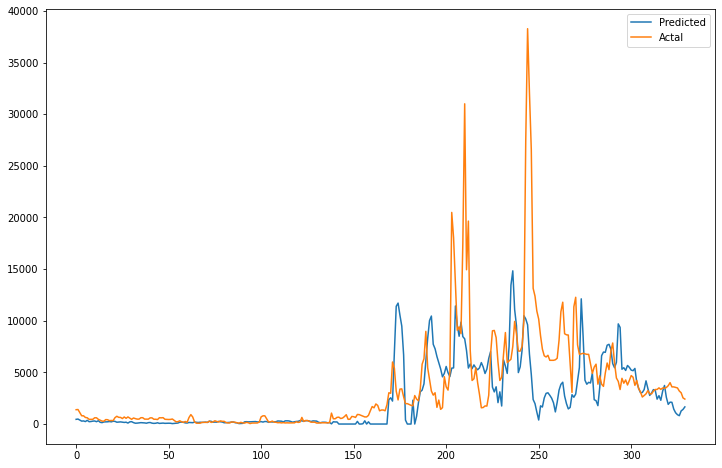

In [ ]:
y_actual, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        x_month = xb[0].cuda()
        x_day = xb[1].cuda()
        x_season = xb[2].cuda()
        x_prev_data = xb[3].cuda()

        y_hat = model(x_month, x_day, x_season, x_prev_data)

        y_actual += yb.data.tolist()
        y_pred += y_hat.cpu().data.tolist()

y_actual = np.array(y_actual).flatten()
y_pred = np.array(y_pred).flatten()

plt.figure(figsize=(12, 8))
plt.plot(y_pred, label='Predicted')
plt.plot(y_actual, label='Actal')
plt.legend()
plt.show()

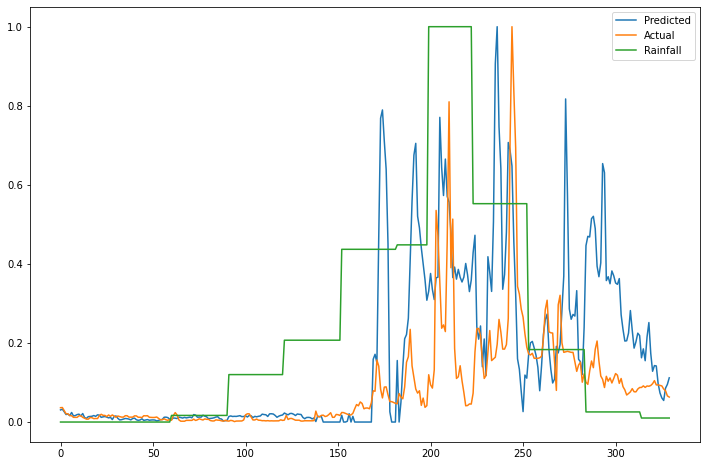

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_pred / y_pred.max(), label='Predicted')
plt.plot(y_actual / y_actual.max(), label='Actual')
plt.plot(inflow_df[inflow_df['YEAR'].isin(['2020'])]['RAINFALL'].values / inflow_df[inflow_df['YEAR'].isin(['2020'])]['RAINFALL'].max(), label='Rainfall')

plt.legend()
plt.show()

### Prediction on entire Dataset

In [ ]:
def pred(df):
    pred_ds = InflowDataset(df.copy())
    pred_dl = DataLoader(pred_ds, batch_size=len(pred_ds))

    model.eval()
    with torch.no_grad():
        for x, y in pred_dl:
            x_month = x[0].cuda()
            x_day = x[1].cuda()
            x_season = x[2].cuda()
            x_prev_data = x[3].cuda()

            y_hat = model(x_month, x_day, x_season, x_prev_data)

    return y_hat.data.cpu().view(-1).tolist()

In [ ]:
model_test_df = inflow_df.sort_values(by=['YEAR', 'DAY']).copy()
model_test_df['Predicted_Inflow'] = pred(model_test_df)
model_test_df[:10]

,INFLOW_CUSECS,YEAR,MONTH,DAY,RAINFALL,SEASON,Predicted_Inflow
0,2029.0,2011,1,0,0.0226,WINTER,1738.722168
1,3084.0,2011,1,1,0.0226,WINTER,2575.858643
2,2776.0,2011,1,2,0.0226,WINTER,2187.477783
3,2311.0,2011,1,3,0.0226,WINTER,1945.265381
4,1847.0,2011,1,4,0.0226,WINTER,1558.078003
5,2156.0,2011,1,5,0.0226,WINTER,1846.353760
6,1847.0,2011,1,6,0.0226,WINTER,1446.373047
7,2002.0,2011,1,7,0.0226,WINTER,1640.990601
8,1537.0,2011,1,8,0.0226,WINTER,1302.377808
9,1382.0,2011,1,9,0.0226,WINTER,1123.282715


In [ ]:
avg_daily_pred_inflow = model_test_df.groupby('DAY')['Predicted_Inflow'].mean().values
avg_daily_actual_inflow = model_test_df.groupby('DAY')['INFLOW_CUSECS'].mean().values
avg_daily_actual_rainfall = model_test_df.groupby('DAY')['RAINFALL'].mean().values

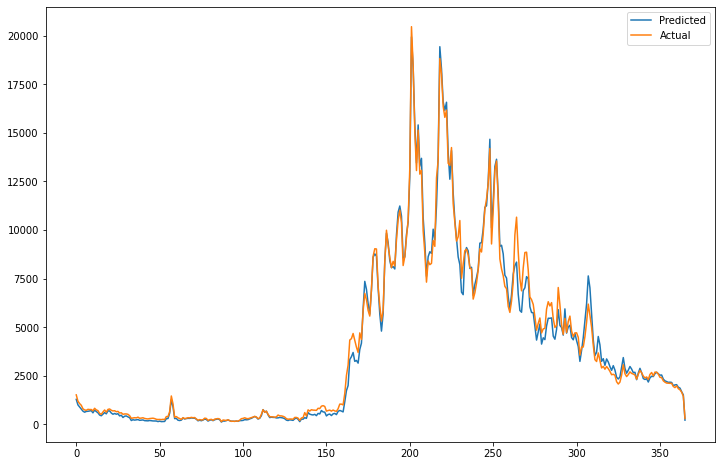

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(avg_daily_pred_inflow, label='Predicted')
plt.plot(avg_daily_actual_inflow, label='Actual')
plt.legend()
plt.show()

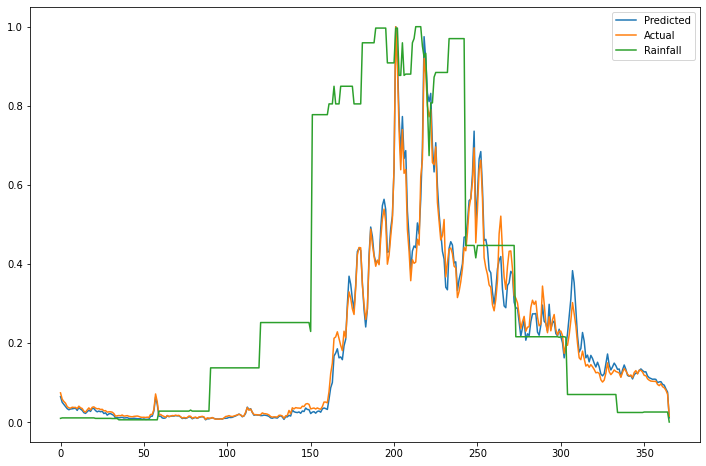

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(avg_daily_pred_inflow / avg_daily_pred_inflow.max(), label='Predicted')
plt.plot(avg_daily_actual_inflow / avg_daily_actual_inflow.max(), label='Actual')
plt.plot(avg_daily_actual_rainfall / avg_daily_actual_rainfall.max(), label='Rainfall')

plt.legend()
plt.show()

In [ ]:
model_test_df['YEAR-MONTH-DAY'] = model_test_df['YEAR'].astype(str) + '-' + model_test_df['MONTH'].astype(str) + '-' + model_test_df['DAY'].astype(str)
model_test_df.set_index('YEAR-MONTH-DAY', inplace=True)
model_test_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DAY,RAINFALL,SEASON,Predicted_Inflow
YEAR-MONTH-DAY,,,,,,,
2011-1-0,2029.0,2011,1,0,0.0226,WINTER,1738.722168
2011-1-1,3084.0,2011,1,1,0.0226,WINTER,2575.858643
2011-1-2,2776.0,2011,1,2,0.0226,WINTER,2187.477783
2011-1-3,2311.0,2011,1,3,0.0226,WINTER,1945.265381
2011-1-4,1847.0,2011,1,4,0.0226,WINTER,1558.078003


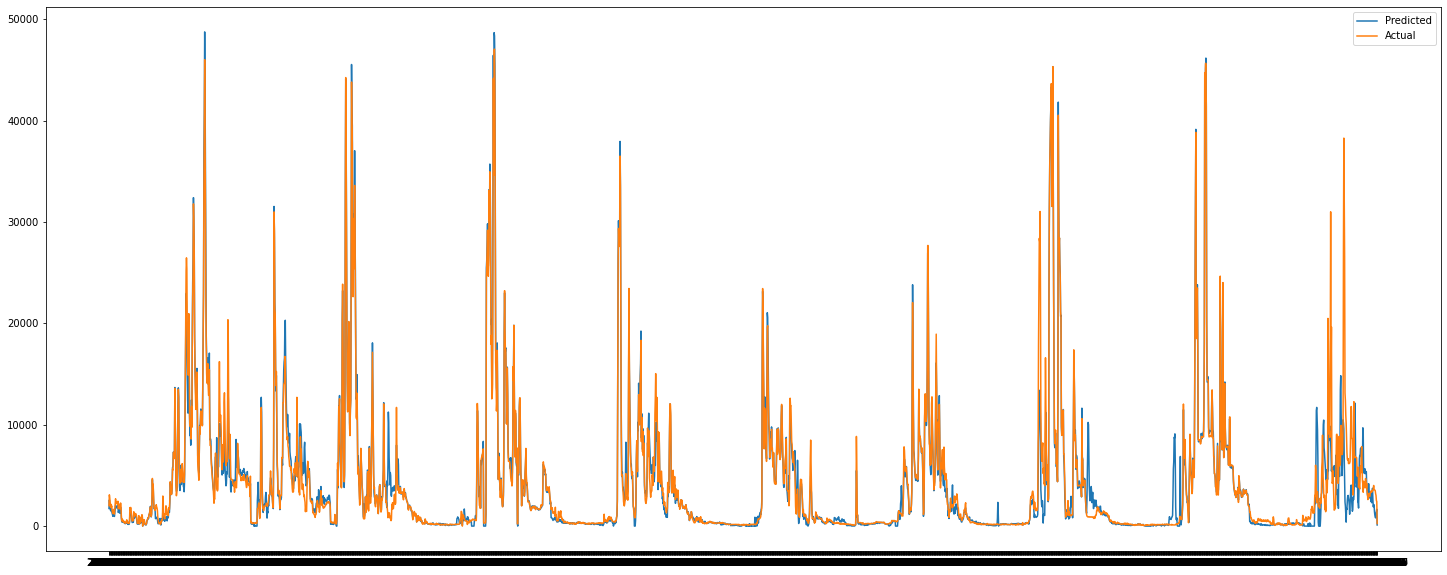

In [ ]:
plt.figure(figsize=(25, 10))
plt.plot(model_test_df['Predicted_Inflow'], label='Predicted')
plt.plot(model_test_df['INFLOW_CUSECS'], label='Actual')
plt.legend()
plt.show()

In [ ]:
((model_test_df['INFLOW_CUSECS'] - model_test_df['Predicted_Inflow']) ** 2).mean() ** .5

1778.4430794775487

In [ ]:
captum_test_input, _ = InflowDataset(inflow_df[(inflow_df['YEAR'] == 2020) & (inflow_df['DAY'] == 216)].reset_index(drop=True).copy())[0]
captum_test_input = [data.view(1, -1) for data in captum_test_input]
captum_test_input

[tensor([[7]]),
 tensor([[216]]),
 tensor([[0]]),
 tensor([[1022.0333,   82.0000]])]

In [ ]:
attr_algo = IntegratedGradients(model)
attributions = attr_algo.attribute(captum_test_input)

AssertionError: ignored

In [ ]:
torch.save(model.state_dict(), 'krs_inflow_model_state.pth')